<a href="https://colab.research.google.com/github/i4ata/3BP/blob/main/DataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation

In this notebook, I generate trajectories of three bodies in 2D.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time
from tqdm import tqdm
import numba as nb
import os

from google.colab import drive
drive.mount('/content/gdrive')

from typing import Tuple

np.seterr(invalid = 'ignore')
np.random.seed(12345)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Path where I want to save the data
path = os.path.join("gdrive", "MyDrive", "Colab Notebooks", "3BP")

In [4]:
# Defining constants
step = 0.001    # dt
max_t = 5       # total time
M = np.ones(3)  # masses of the bodies
G = 1           # gravitational constant
step_sq = step**2

t = np.arange(start = 0, stop = max_t, step = step)

In [5]:
# Initialize the system
@nb.njit
def setup() -> np.array:
    rs = np.random.uniform(1, 1.5, size = 3)
    thetas = np.array([rd.uniform(0, 2*np.pi/3), rd.uniform(2*np.pi/3, 4*np.pi/3), rd.uniform(4*np.pi/3, 2*np.pi)])
    return np.concatenate((
        rs * np.cos(thetas), # xs
        rs * np.sin(thetas), # ys
        np.random.uniform(-.3, .3, size = 6)  # velocities
    ))

In [6]:
# display trajectories
def show(x : np.array, y : np.array) -> None:
  
    plt.figure(figsize = (8, 8))
    plt.plot(x[:,0], y[:,0], color = 'green')
    plt.plot(x[:,1], y[:,1], color = 'blue')
    plt.plot(x[:,2], y[:,2], color = 'red')
    plt.scatter(x[0][0], y[0][0], color = 'green')
    plt.scatter(x[0][1], y[0][1], color = 'blue')
    plt.scatter(x[0][2], y[0][2], color = 'red')
    plt.grid()
    plt.xlim(np.amin(x) - 0.2, np.amax(x) + 0.2)
    plt.ylim(np.amin(y) - 0.2, np.amax(y) + 0.2)

    plt.show()

In [7]:
@nb.njit
def nan_to_num(arr : np.array) -> np.array:
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]):
            arr[i] = 0
    return arr

In [8]:
@nb.njit
def compute_acceleration(x : np.array, y : np.array, 
                         ax : np.array, ay : np.array, 
                         M : np.array = np.ones(3), 
                         G : float = 1.,
                         eps : float = .1) -> Tuple[np.array, np.array]:

    for i in range(3):

        dx = (x[i] - x).T
        dy = (y[i] - y).T

        r = np.linalg.norm(dx - dy)
        r = np.maximum(r, eps)
        d = r ** 3

        ax[:, i] = nan_to_num(-dx*M*G / d)
        ay[:, i] = nan_to_num(-dy*M*G / d)

    ax_tot = np.sum(ax, axis=0)
    ay_tot = np.sum(ay, axis=0)

    return ax_tot, ay_tot

In [9]:
# compute trajectories
@nb.njit
def run_verlet(init : np.array = None) -> Tuple[np.array, np.array, np.array, np.array]:

    x = np.zeros(shape = (len(t) + 1, 3))
    y = np.zeros(shape = (len(t) + 1, 3))

    vx = np.zeros(shape = (len(t) + 1, 3))
    vy = np.zeros(shape = (len(t) + 1, 3))

    ax = np.zeros(shape = (3, 3))
    ay = np.zeros(shape = (3, 3))

    if init is None:
        init = setup()

    x[0] = init[:3]
    y[0] = init[3:6]

    vx[0] = init[6:9]
    vy[0] = init[9:]

    for i in range(len(t)):
        ax_tot, ay_tot = compute_acceleration(x[i], y[i], ax, ay)

        x[i+1] = x[i] + step * vx[i] + .5 * ax_tot * step_sq
        y[i+1] = y[i] + step * vy[i] + .5 * ay_tot * step_sq

        ax_tot_next, ay_tot_next = compute_acceleration(x[i+1], y[i+1], ax, ay)

        vx[i+1] = vx[i] + .5 * (ax_tot + ax_tot_next) * step
        vy[i+1] = vy[i] + .5 * (ay_tot + ay_tot_next) * step



    return x, y, vx, vy

In [10]:
cool_setup = np.array([-0.48030582, -1.37429829, -1.28950245,  0.33897823,  
                       0.94316374, 0.27974152,  0.47623917,  0.49406879, 
                       -0.03630416, -0.27530146, -0.46907631, -0.61953578])

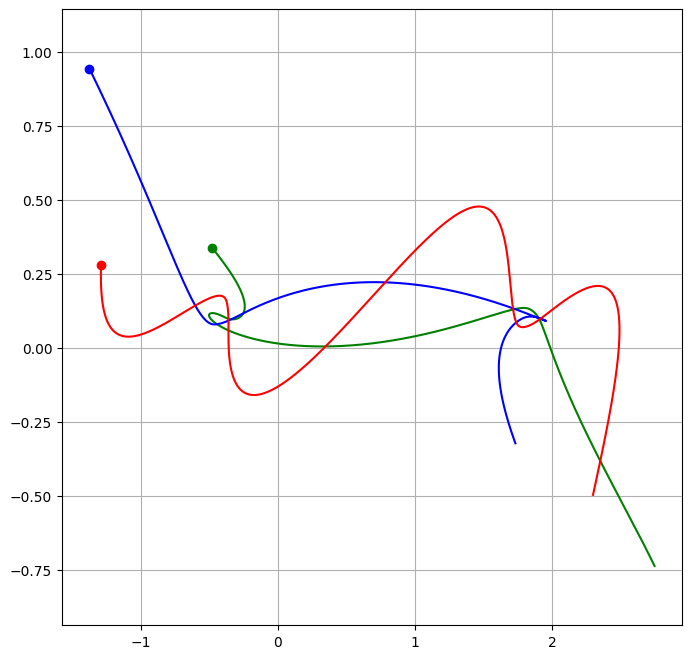

In [11]:
xs, ys, vxs, vys = run_verlet(init = cool_setup)
show(xs, ys)

In [12]:
def generate_data(samples = 1_000):
    output = np.zeros((len(t) + 1, 12, samples))
    for sample in tqdm(range(samples)):
        output[:, :, sample] = np.concatenate(run_verlet(), axis = 1)
    return output

In [13]:
def clean_data(a, threshold = 6):
    mask = (np.abs(a) < threshold).all(axis = (0,1))
    return a[:, :, mask]

In [14]:
for i in range(10):
  data = generate_data()
  np.save(path + f"/data{i}.npy", clean_data(data))

100%|██████████| 1000/1000 [00:35<00:00, 27.83it/s]


In [15]:
for i in range(10, 20):
  data = generate_data()
  np.save(path + f"/data{i}.npy", clean_data(data))

100%|██████████| 1000/1000 [00:35<00:00, 28.13it/s]
